# Dynamically changing the behavior of objects

Import some modules.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import types

## Decorator design pattern

The decorator design pattern is used when you want to (dynamically) modify the behavior of specific instances of a class, 

Consider a class that represents a random walk in one dimension.

In [2]:
class RandomWalker:
    
    def __init__(self):
        self.pos = 0.0
        
    @property
    def pos(self):
        return self._pos
    
    @pos.setter
    def pos(self, value):
        self._pos = float(value)
        
    def step(self):
        old_pos = self.pos
        self.pos += 2.0*(random.random() - 0.5)
        return old_pos

A walker is instantiated, it takes 50 steps, and the result is plotted.

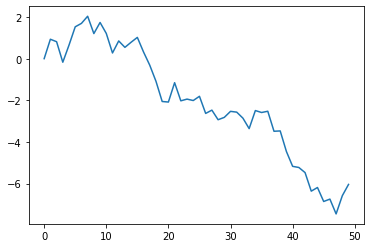

In [3]:
random.seed(1234)
walker = RandomWalker()
data = [walker.step() for _ in range(50)]
_ = plt.plot(data)

Now suppose you want a walker that is "clamped", i.e., one that can move at most a given distance from the origin in both dimensions.

We start by defining a `Decorator` class.  An instance of this class simply takes an object, returns the attributes and executes the methods of that object, except those that have been added to or overridden in the Decorator class.  By itself, `Decorator` acts like a no-op, a decorated object will behave exactly the same.

In [4]:
class Decorator:
    
    def __init__(self, object):
        self.__dict__['_object'] = object
        
    def __hasattr__(self, name):
        return name in dir(self) or hasattr(self._object, name)
    
    def __getattr__(self, name):
        if name in dir(self):
            return getattr(self, name)
        else:
            return getattr(self._object, name)
            
    def __setattr__(self, name, value):
        if name in dir(self):
            setattr(self, name, value)
        elif hasattr(self._object, name):
            setattr(self._object, name, value)
        else:
            self.__dict__[name] = value


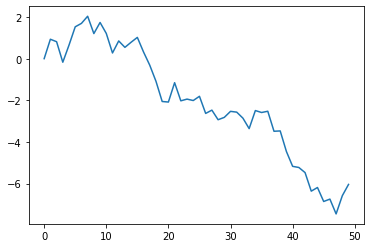

In [5]:
random.seed(1234)
decorated_walker = Decorator(RandomWalker())
data = [decorated_walker.step() for _ in range(50)]
plt.plot(data);

However, if `Decorator` is used as the base class for a class that overrides `RandomWalker`'s `step` method, the resulting object acts differently.

In [6]:
class Clamp(Decorator):
    
    def __init__(self, object, min_val, max_val):
        super().__init__(object)
        self._min_val = min_val
        self._max_val = max_val
        
    def step(self):
        old_pos = self.pos
        new_pos = self.pos + 2.0*(random.random() - 0.5)
        while new_pos < self._min_val or new_pos > self._max_val:
            new_pos = self.pos + 2.0*(random.random() - 0.5)
        self.pos = new_pos
        return old_pos    

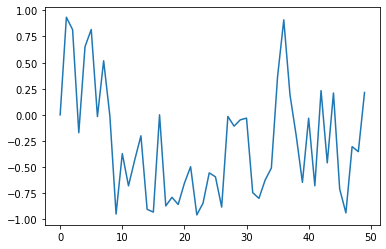

In [7]:
random.seed(1234)
clamped_walker = Clamp(RandomWalker(), -1.0, 1.0)
data = [clamped_walker.step() for _ in range(50)]
plt.plot(data);

To illustrate the dynamic character of decorators, we instantiate a `RandomWalker` and decorate it with the `Clamp` decorator.  It executes 25 steps, and after that the original `RandomWalker` executes another 25, "escaping" out of the interval $[-1, +1]$.

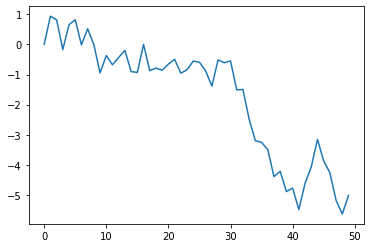

In [8]:
random.seed(1234)
walker = RandomWalker()
clamped_walker = Clamp(walker, -1.0, 1.0)
data = [clamped_walker.step() for _ in range(25)]
data += [walker.step() for _ in range(25)]
plt.plot(data);

Note that decorators can be orthogonal, i.e., we can define another decorator that makes a `RandomWalker` resettable.

In [9]:
class Resettable(Decorator):
    
    def reset(self):
        self._object.pos = 0.0

To illustrate that decorators can be combined, we instantiate a `RandomWalker`, clamp it, make it resettable, and execute 50 steps, resetting every 10.

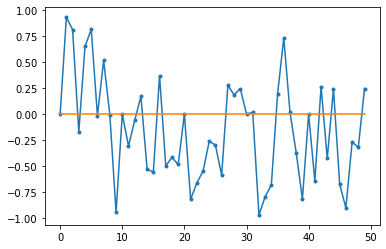

In [10]:
random.seed(1234)
walker = Resettable(Clamp(RandomWalker(), -1.0, 1.0))
data = list()
for _ in range(5):
    walker.reset()
    data += [walker.step() for _ in range(10)]
plt.plot(data, '.-');
plt.plot([0.0]*50);

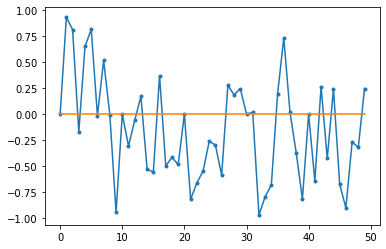

In [11]:
random.seed(1234)
walker = Clamp(Resettable(RandomWalker()), -1.0, 1.0)
data = list()
for _ in range(5):
    walker.reset()
    data += [walker.step() for _ in range(10)]
plt.plot(data, '.-');
plt.plot([0.0]*50);

## Alternative: context managers

In Python, the same goal can be achieved by replacing the implementation of a method after the object has been created.  We define an ordinary function `step` that implements the same algorithm as the corresponding method defined in the `Clamp` class.

In [12]:
def step(walker):
    new_pos = walker.pos + 2.0*(random.random() - 0.5)
    while new_pos < walker._min_val or new_pos > walker._max_val:
        new_pos = walker.pos + 2.0*(random.random() - 0.5)
    walker._pos = new_pos
    return walker.pos    

Just as when using the `Clamp` decorator, this walker should executes 25 steps "clamped" in the interval $[-1, +1]$, and after that it should executes another 25 steps using its original method, "escaping" out of the interval $[-1, +1]$.

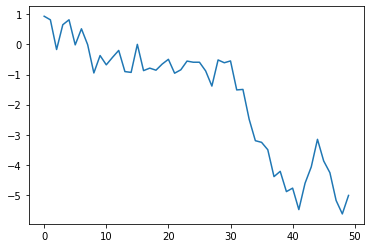

In [13]:
random.seed(1234)
walker = RandomWalker()
orig_step = walker.step
walker.step = types.MethodType(step, walker)
walker._min_val = -1.0
walker._max_val = 1.0
data = [walker.step() for _ in range(25)]
walker.step = orig_step
del walker._min_val
del walker._max_val
data += [walker.step() for _ in range(25)]
plt.plot(data);

But wait, although this is messy, can we clean it up?  Yes, using context managers.

In [14]:
import contextlib

In [15]:
def create_bound_step(min_val, max_val):
    def step(walker):
        nonlocal min_val, max_val
        new_pos = walker.pos + 2.0*(random.random() - 0.5)
        while new_pos < min_val or new_pos > max_val:
            new_pos = walker.pos + 2.0*(random.random() - 0.5)
        walker._pos = new_pos
        return walker.pos
    return step

In [16]:
@contextlib.contextmanager
def decorate(obj, name, function):
    orig_function = getattr(obj, name)
    setattr(obj, name, types.MethodType(function, obj))
    yield obj
    setattr(obj, name, orig_function)

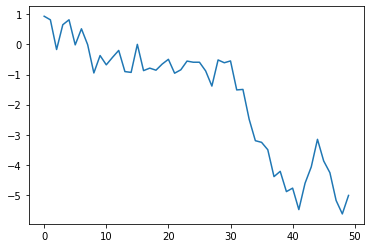

In [17]:
walker = RandomWalker()
random.seed(1234)
with decorate(walker, 'step', create_bound_step(-1.0, 1.0)) as bound_walker:
    data = [bound_walker.step() for _ in range(25)]
data += [walker.step() for _ in range(25)]
plt.plot(data);

Note that although it would be possible to compose multiple decorators, it is not so obvious to do this using context managers.